<h1 align="center">Autoencoders and Collaborative Filtering in Keras</h1>

## Import Libraries

In [19]:
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict
import scipy.sparse as sps
from sklearn.utils import shuffle
from builtins import range

from scipy.sparse import save_npz, load_npz

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dropout, Dense
from keras.regularizers import l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
%matplotlib inline

FILE_PATH = "./data/Movielens/"

## Load the data

In [5]:
## user_to_item_map={}  ## Key:= User_id, Value:= [list of items] 
## item_to_user_map={}  ## Key:= item_id, Value:=[list of users] 
## train_ratings={}      ## Key:= (User_id, item_id) Value:=Rating 
## test_ratings={}       ## Key:= (User_id, item_id) Value:=Rating 

with open(FILE_PATH+'user_to_item_map.pkl', 'rb') as fp:
    user_to_item_map=pickle.load(fp)

with open(FILE_PATH+'item_to_user_map.pkl', 'rb') as fp:
    item_to_user_map=pickle.load(fp)

with open(FILE_PATH+'train_ratings.pkl', 'rb') as fp:
    train_ratings=pickle.load(fp)

with open(FILE_PATH+'test_ratings.pkl', 'rb') as fp:
    test_ratings=pickle.load(fp)

## Preprocessing

In [6]:
## Transforming data to sparse matices
n_users=len(user_to_item_map)
n_items=len(item_to_user_map)

train_matrix=sps.lil_matrix((n_users,n_items))
test_matrix=sps.lil_matrix((n_users,n_items))

for (user,item),rating in train_ratings.items():
    train_matrix[user,item]=rating
    
for (user,item),rating in test_ratings.items():
    test_matrix[user,item]=rating

train_mask=(train_matrix>0)*1.0
test_mask=(test_matrix>0)*1.0

In [7]:
## Keeping a copy of the originals to deal with shuffle
train_matrix1=train_matrix.copy()
test_matrix1=test_matrix.copy()
train_mask1=train_mask.copy()
test_mask1=test_mask.copy()

In [8]:
mean=train_matrix.sum()/train_mask.sum()

In [9]:
## Defining the loss function
def loss(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, 0), dtype='float32')
    diff = y_pred - y_true
    sqdiff = diff * diff * mask
    sse = K.sum(K.sum(sqdiff))
    n = K.sum(K.sum(mask))
    return sse / n

In [10]:
def train_generator(matrix, mask, batch_size):
    while True:
        matrix, mask = shuffle(matrix, mask)
        for i in range(matrix.shape[0]// batch_size + 1):    ## batch_size + 1
            upper = min((i+1)*batch_size, matrix.shape[0])
            a = matrix[i*batch_size:upper].toarray()
            m = mask[i*batch_size:upper].toarray()
            a = a - mean * m # must keep zeros at zero!
            
            # m2 = (np.random.random(a.shape) > 0.5)
            # noisy = a * m2
            noisy = a # no noise
            yield noisy, a


def test_generator(matrix, mask, matrix_test, mask_test, batch_size):
    while True:
        for i in range(matrix.shape[0]// batch_size + 1):  ## batch_size + 1
            upper = min((i+1)*batch_size, matrix.shape[0])
            a = matrix[i*batch_size:upper].toarray()
            m = mask[i*batch_size:upper].toarray()
            at = matrix_test[i*batch_size:upper].toarray()
            mt = mask_test[i*batch_size:upper].toarray()
            a = a - mean * m
            at = at - mean * mt
            yield a, at

## Autoencoder Model

In [27]:
def get_model():
    i = Input(shape=(n_items,))
    x = Dropout(0.7)(i)
    x = Dense(100, activation='tanh')(x)
    x = Dense(n_items)(x)
    model = Model(inputs=i, outputs=x)
    return model
model=get_model()
model.compile( loss=loss, optimizer='adam',metrics=[loss])

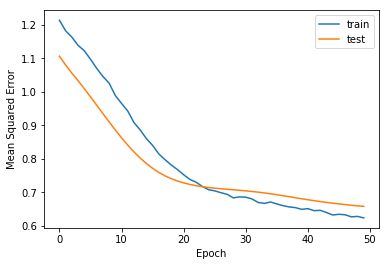

In [28]:
batch_size=1024
epochs=50

history = model.fit_generator( train_generator(train_matrix, train_mask, batch_size), 
                        validation_data=test_generator(train_matrix1, train_mask1, test_matrix1, test_mask1,batch_size),
                        epochs=epochs, steps_per_epoch=train_matrix.shape[0]// batch_size + 1,
                        validation_steps=test_matrix.shape[0]// batch_size + 1,verbose=0)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper right')
plt.show()